In [2]:
#导入相关包
import pandas as pd
import numpy as np
from snownlp import SnowNLP #情感分析
import jieba
import pyLDAvis.gensim       #LDA可视化
import wordcloud             #词云
import os, codecs
import seaborn as sns
from pylab import mpl
import jieba.posseg as pseg
import matplotlib.pyplot as plt
from collections import Counter
from gensim import corpora,models

# 预处理

In [3]:
#导入数据
df=pd.read_csv('F:\民俗古镇1.csv')
df1= df['text']
#df1.head()

In [4]:
#查询重复值
df1.duplicated().value_counts() 

False    3927
True       23
Name: text, dtype: int64

In [5]:
#处理重复值
df2= df1.drop_duplicates()
df2.duplicated().value_counts()

False    3927
Name: text, dtype: int64

In [6]:
#去除短句，保留长度大于5的数据
df3 = df2[df2.str.len()>5]
df3 = df3.reset_index(drop=True)
data = df3.tolist()            #list形式

In [7]:
df3.head()

0    西江千户苗寨的住所建筑有很大的少数民族风貌 依山而建 （新建的）可以租套苗衣 （头饰 挂的饰...
1    馆内珍藏有1220余件苗族文物和350余张有代表性的图片、画像、书籍，从苗族历史、生产、生活...
2    去西江千户苗寨必定要去看看这个博物馆，位于寨子中心区，无需门票。馆内珍藏有1220余件苗族文...
3    含在西江苗寨的门票里向游客展示了苗族的主要生活形态祭祀节日苗寨的建筑风格苗药的各种药材苗族的...
4    苗寨要住一晚上才会看到夜景，如果仅仅白天意思不是太大。还是建议大家旅游不能赶，要慢慢体验。酸...
Name: text, dtype: object

# 分词

In [8]:
def load_stopword():
    '''
    加载停用词表
    :return: 返回停用词的列表
    '''
    f_stop = open('E:\课程相关\大三下\综合课程设计\stopWord.txt','r',encoding='UTF-8')
    sw = [line.strip() for line in f_stop]
    f_stop.close()
    sw.append('\n')
    return sw

<>:6: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \s
<ipython-input-8-4c5bede52888>:6: DeprecationWarning: invalid escape sequence \s
  f_stop = open('E:\课程相关\大三下\综合课程设计\stopWord.txt','r',encoding='UTF-8')


In [10]:
stopwords = load_stopword()  #加载停用词表
jieba.load_userdict("E:\课程相关\大三下\综合课程设计\dict.txt")  #自定义字典
text_list = []
cloud_text = ''
c = Counter()
for i in range(len(df3)):
    seg_list = jieba.posseg.cut(df3[i])
    mytext_list=[]
    for x in seg_list:
        if len(x.word)>1 and x.word != '\r\n' and x.word not in stopwords and x.flag =='n':   #x.flag =='n'表示只保留名词
            c[x.word] += 1
            mytext_list.append(x.word.replace(" ",""))
    text_list.append(mytext_list)      
    cloud_text+=",".join(mytext_list)  #绘制词云
print('词频度统计结果')
for (k,v) in c.most_common(10):
    print('{}:{}'.format(k,v))

<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
<ipython-input-10-c28050539b20>:2: DeprecationWarning: invalid escape sequence \d
  jieba.load_userdict("E:\课程相关\大三下\综合课程设计\dict.txt")  #自定义字典


词频度统计结果
门票:504
特色:384
博物馆:377
建筑:365
文化:347
景色:311
历史:293
风景:266
时间:248
游客:234


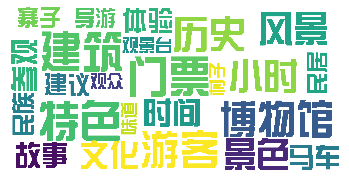

In [11]:
#创建词云
font = "C:\\Windows\\Fonts\\HGZY_CNKI.TTF"#词云的中文字体所在路径
wc = wordcloud.WordCloud(
    scale = 7,
    background_color="white", #背景颜色
    #max_words=200, #显示最大词数
    font_path=font,
    min_font_size=15,
    max_font_size=50, 
    width=400  #图幅宽度
    )
wc.generate(cloud_text)

plt.imshow(wc)
plt.axis("off")
plt.show()

# LDA主题分析

In [12]:
# 主题分析
text_dict = corpora.Dictionary(text_list) # 创建语料的词语词典，每个单独的词语都会被赋予一个索引
text_corpus = [text_dict.doc2bow(i) for i in text_list] #创建语料库
tfidf = models.TfidfModel(text_corpus)
corpus_tfidf = tfidf[text_corpus]

In [ ]:
#模型评估：困惑度 &一致度
x_list = []
y_plist =[]
y_clist =[]
for i in range(2,50):
    text_lda = models.LdaModel(corpus_tfidf,num_topics = i,id2word =text_dict ) # LDA模型训练
    #困惑度
    perplexity = text_lda.log_perplexity(corpus_tfidf)  
    #一致度
    cv_tmp = models.CoherenceModel(model=text_lda,texts=text_list, dictionary=text_dict, coherence='c_v')
    x_list.append(i)
    y_plist.append(perplexity)
    y_clist.append(cv_tmp.get_coherence())
#困惑度绘图    
plt.figure(figsize=(30,15))    
plt.subplot(1,2,1)
plt.plot(x_list,y_plist)
plt.xticks(np.linspace(0, 50, 51))
plt.xlabel('num topics')
plt.ylabel('perplexity score')
plt.legend(('perplexity_values'), loc='best')
#一致度绘图
plt.subplot(1,2,2)
plt.plot(x_list,y_clist)
plt.xticks(np.linspace(0, 50, 51))
plt.xlabel('num topics')
plt.ylabel('coherence score')
plt.legend(('coherence_values'), loc='best')

plt.show()

In [13]:
#根据以上模型评估结果分析最优主题数目

In [19]:
#最优主题数目下的LDA主题模型
n = 33
lda = models.LdaModel(text_corpus,num_topics =n,id2word =text_dict ) # LDA模型训练  该最优主题数为32
for i in range(n):
    print('topic' + str(i))
    print(lda.print_topic(i)) # 输出每个主题

topic0
0.038*"森林公园" + 0.025*"古迹" + 0.023*"历史" + 0.022*"风景" + 0.022*"特色" + 0.018*"小时" + 0.017*"风光" + 0.016*"环线" + 0.015*"建筑" + 0.013*"游人"
topic1
0.027*"花桥" + 0.023*"体验" + 0.022*"鼓楼" + 0.019*"特色" + 0.016*"名气" + 0.016*"景色" + 0.016*"风景" + 0.015*"路线" + 0.011*"民俗" + 0.011*"建筑"
topic2
0.074*"时间" + 0.040*"瓷器" + 0.040*"游玩" + 0.023*"景色" + 0.020*"河道" + 0.020*"博物馆" + 0.016*"时代" + 0.014*"特点" + 0.012*"环境" + 0.012*"村庄"
topic3
0.070*"风景" + 0.028*"美誉" + 0.026*"很漂亮" + 0.025*"性价比" + 0.021*"名字" + 0.016*"故事" + 0.014*"历史" + 0.013*"走廊" + 0.012*"体力" + 0.012*"价格"
topic4
0.085*"门票" + 0.054*"博物馆" + 0.030*"参观" + 0.020*"陶瓷" + 0.018*"民间" + 0.017*"文化" + 0.015*"建筑" + 0.014*"名胜" + 0.014*"特色" + 0.014*"老街"
topic5
0.053*"观景台" + 0.023*"导游" + 0.023*"风景" + 0.022*"参观" + 0.020*"门票" + 0.018*"游客" + 0.015*"房间" + 0.014*"山景" + 0.014*"检票" + 0.012*"特色"
topic6
0.074*"景色" + 0.023*"天气" + 0.019*"空气" + 0.015*"取景" + 0.014*"住宅" + 0.013*"街道" + 0.013*"博物馆" + 0.011*"建筑" + 0.010*"特色" + 0.009*"门票"
topic7
0.042*"长廊" + 0.038*"文化" + 0.031*"历史" + 0

In [14]:
#可视化模型，帮助理解主题
#vis_data = pyLDAvis.gensim.prepare(lda, text_corpus,text_dict)
#pyLDAvis.show(vis_data, open_browser=False)

In [15]:
#得到每个文档（每评论文本）的主导主题
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [16]:
#文档中贡献百分比最高的主题
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=text_corpus, texts=data)# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']# Show
df_dominant_topic.head(10)
#df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,32.0,0.9485,"游客, 饭店, 少数民族, 民族, 作坊, 商业, 特色, 网络, 门票, 小巷",西江千户苗寨的住所建筑有很大的少数民族风貌 依山而建 （新建的）可以租套苗衣 （头饰 挂的饰...
1,1,23.0,0.9430,"博物馆, 后裔, 河道, 建筑, 景色, 文化, 特色, 后人, 房屋, 门票",馆内珍藏有1220余件苗族文物和350余张有代表性的图片、画像、书籍，从苗族历史、生产、生活...
2,2,23.0,0.7501,"博物馆, 后裔, 河道, 建筑, 景色, 文化, 特色, 后人, 房屋, 门票",去西江千户苗寨必定要去看看这个博物馆，位于寨子中心区，无需门票。馆内珍藏有1220余件苗族文...
3,3,10.0,0.6052,"观景台, 风景, 门票, 名胜, 花桥, 建筑, 商业街, 海拔, 时间, 茶园",含在西江苗寨的门票里向游客展示了苗族的主要生活形态祭祀节日苗寨的建筑风格苗药的各种药材苗族的...
4,4,9.0,0.8788,"游玩, 门票, 古迹, 商业化, 环保车, 风格, 气息, 特色, 收费, 历史",苗寨要住一晚上才会看到夜景，如果仅仅白天意思不是太大。还是建议大家旅游不能赶，要慢慢体验。酸...
5,5,15.0,0.4892,"门票, 宅子, 长廊, 聚宝盆, 游客, 荷花, 博物馆, 历史, 建筑, 森林公园",比黔东南民族博物馆再降一个档次 图文展示内容态度太多 但是去苗寨还是去这里了解一下历史文化比...
6,6,6.0,0.5728,"门票, 博物馆, 故居, 建筑, 参观, 图片, 检票, 历史, 唱歌, 民宿",很好的景点，就是人太多了，导致住宿价格搞得离谱，建议不要七八月份来。餐饮的价格倒是管理的不错...
7,7,15.0,0.6717,"门票, 宅子, 长廊, 聚宝盆, 游客, 荷花, 博物馆, 历史, 建筑, 森林公园",是大门票里包括的，拿身份证或者门票进入，是个典型的苗寨宅子，里面有宗教丧葬农耕历史等等主题的...
8,8,7.0,0.9596,"苗家, 特色, 文化, 走路, 小吃, 婆婆, 古色古香, 博物, 体验, 经济",西江苗族博物館，位於西江千戶苗寨景區內，博物館建築的外觀，恰似苗族吊腳樓。博物館內設有歷史、...
9,9,17.0,0.9030,"美景, 民俗, 历史, 小时, 民风, 关键, 工作人员, 建议, 关门, 时间",每天九点开门。原说凭西江门票或身份证进。真进去后工作人员也不查。内容丰富。其历史、装饰、服装...


In [17]:
len(df_dominant_topic)

3922

# 通过可视化模型以及每个主题的主导文档手动合并几个主题，然后再进行下一步（情感分析）

In [24]:
df_dominant_topic['Topic'] = None
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([0,3,6,8,15])] = '自然风景'
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([1,7,11,18,19,22,25,28])] = '人文环境'
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([5,9,13,14,16,21,23,24,26,29,30,31,32])] = '顾客体验'
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([4,10,12,17,20,27])] = '民俗文化'
df_dominant_topic.fillna('others',inplace = True)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCo

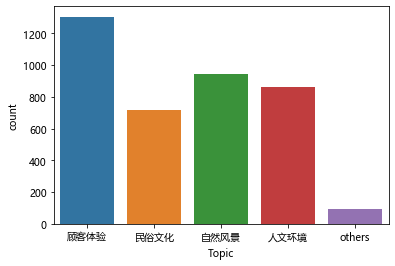

In [25]:
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
sns.countplot(df_dominant_topic['Topic'])

#  情感分析

In [26]:
Attitude = []    
for i, v in df_dominant_topic['Text'].iteritems():
    s = SnowNLP(v)
    Attitude.append(s.sentiments)
df_dominant_topic['Attitude'] = Attitude

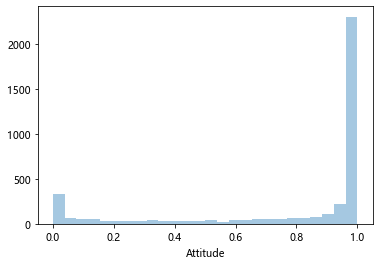

In [27]:
#所有主题的情感倾向分布情况
sns.distplot(df_dominant_topic['Attitude'],kde = False)

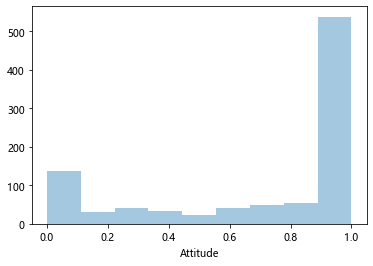

In [28]:
#某个主题的情感倾向分布情况-自然风景
sns.distplot(df_dominant_topic[df_dominant_topic['Topic']=='自然风景']['Attitude'],kde = False)# 主题35的情感倾向

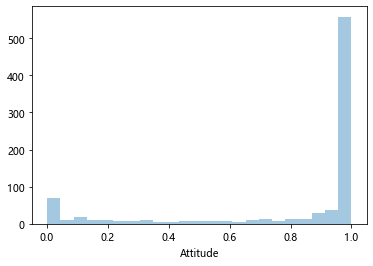

In [29]:
#某个主题的情感倾向分布情况-人文环境
sns.distplot(df_dominant_topic[df_dominant_topic['Topic']=='人文环境']['Attitude'],kde = False)# 主题35的情感倾向

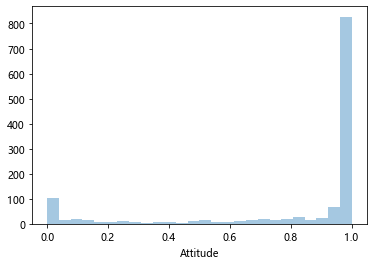

In [30]:
#某个主题的情感倾向分布情况-用户体验
sns.distplot(df_dominant_topic[df_dominant_topic['Topic']=='顾客体验']['Attitude'],kde = False)# 主题35的情感倾向

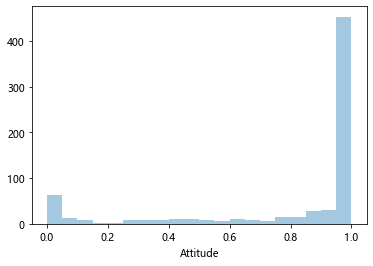

In [31]:
#某个主题的情感倾向分布情况-民俗文化
sns.distplot(df_dominant_topic[df_dominant_topic['Topic']=='民俗文化']['Attitude'],kde = False)# 主题35的情感倾向

# 统计分析

In [35]:
df_gender_fans_sta = pd.merge(df,df_dominant_topic,left_on='text',right_on='Text',how='inner')[['gender','粉丝','text','Topic','Topic_Perc_Contrib']]

In [36]:
df_gender_fans_sta.dropna(inplace = True)

In [38]:
df_gender_fans_sta.head()

,gender,粉丝,text,Topic,Topic_Perc_Contrib
0,male,0.0,西江千户苗寨的住所建筑有很大的少数民族风貌 依山而建 （新建的）可以租套苗衣 （头饰 挂的饰...,顾客体验,0.9485
1,male,73.0,馆内珍藏有1220余件苗族文物和350余张有代表性的图片、画像、书籍，从苗族历史、生产、生活...,顾客体验,0.9430
2,female,1.0,去西江千户苗寨必定要去看看这个博物馆，位于寨子中心区，无需门票。馆内珍藏有1220余件苗族文...,顾客体验,0.7501
3,female,12.0,含在西江苗寨的门票里向游客展示了苗族的主要生活形态祭祀节日苗寨的建筑风格苗药的各种药材苗族的...,民俗文化,0.6052
4,male,22.0,苗寨要住一晚上才会看到夜景，如果仅仅白天意思不是太大。还是建议大家旅游不能赶，要慢慢体验。酸...,顾客体验,0.8788


In [61]:
index = df_gender_fans_sta['Topic'].value_counts(normalize = True, dropna = False).index
statistics = df_gender_fans_sta.groupby(by=['Topic','gender'])['Topic_Perc_Contrib'].sum().values.tolist()


female_count = df_gender_fans_sta[ df_gender_fans_sta['gender']=='female'].shape[0]   #男游客评论人数
male_count = df_gender_fans_sta[ df_gender_fans_sta['gender']=='male'].shape[0]       #女游客评论人数

a,b = [],[]
for i in range(len(statistics)):                                                      #标准化
    if i%2 ==0:
        a.append(statistics[i]/female_count)
    else:
        b.append(statistics[i]/male_count)
for i in range(len(a)):
    a[i],b[i] = a[i]/(a[i]+b[i]),b[i]/(a[i]+b[i])

Index(['顾客体验', '自然风景', '人文环境', '民俗文化', 'others'], dtype='object')


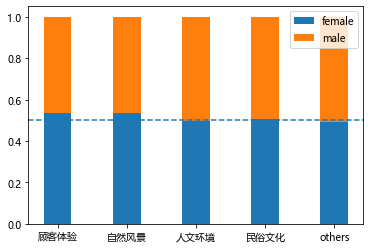

In [60]:
plt.bar(index, a, width=0.4, label='female')
plt.bar(index, b, width=0.4, bottom=a, label= 'male')
plt.axhline(y = 0.5,ls ='--')
plt.legend()
plt.show()

In [63]:
df_gender_fans_sta.groupby(by=['Topic','gender'])['Topic_Perc_Contrib'].sum()

Topic   gender
others  female     31.130900
        male       27.481600
人文环境    female    281.591601
        male      246.390501
民俗文化    female    208.676801
        male      212.546801
自然风景    female    206.609401
        male      203.558301
顾客体验    female    405.238501
        male      425.024601
Name: Topic_Perc_Contrib, dtype: float64

In [291]:
df_gender_fans_sta.groupby(['Topic','gender']).count().T

Topic  others        人文环境        民俗文化        自然风景        顾客体验     
gender female male female male female male female male female male
粉丝        130  106    447  401    436  464    315  360    633  644
text      130  106    447  401    436  464    315  360    633  644

In [292]:
index = df_gender_fans_sta['Topic'].value_counts(normalize = True, dropna = False).index
statistics = df_gender_fans_sta.groupby(['Topic','gender']).text.count().T.values.tolist()

female_count = df_gender_fans_sta[ df_gender_fans_sta['gender']=='female'].shape[0]   #男游客评论人数
male_count = df_gender_fans_sta[ df_gender_fans_sta['gender']=='male'].shape[0]       #女游客评论人数

a,b = [],[]
for i in range(len(statistics)):                                                      #标准化
    if i%2 ==0:
        a.append(statistics[i]/female_count)
    else:
        b.append(statistics[i]/male_count)
for i in range(len(a)):
    a[i],b[i] = a[i]/(a[i]+b[i]),b[i]/(a[i]+b[i])

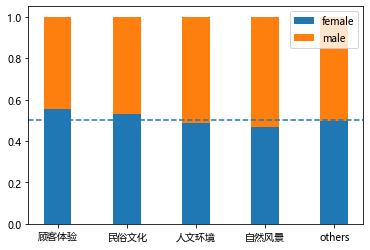

In [293]:
plt.bar(index, a, width=0.4, label='female')
plt.bar(index, b, width=0.4, bottom=a, label= 'male')
plt.axhline(y = 0.5,ls ='--')
plt.legend()
plt.show()

In [322]:
fans_sta = df_gender_fans_sta[df_gender_fans_sta['粉丝']>500].groupby('Topic').text.count()
fans_sta

Topic
others     30
人文环境      114
民俗文化      106
自然风景       53
顾客体验       96
Name: text, dtype: int64

<BarContainer object of 5 artists>

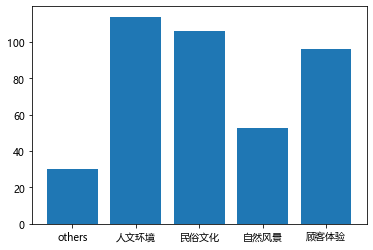

In [320]:
plt.bar(fans_sta.index,fans_sta.tolist())

In [44]:
#找到给定主题最有贡献的文档，并通过阅读该文档来推断该主题
#sent_topics_sorteddf_mallet = pd.DataFrame()

#sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

#for i, grp in sent_topics_outdf_grpd:
#    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],  axis=0)# Reset Index
#sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)# Format
#sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]# Show
#sent_topics_sorteddf_mallet

In [45]:
#主题的数量和分布
#topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()# Percentage of Documents for Each Topic
#topic_contribution = round(topic_counts/topic_counts.sum(), 4)# Topic Number and Keywords
#topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]# Concatenate Column wise
#df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)# Change Column names
#df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']# Show
#df_dominant_topics